# Numerical simulation for double-bracket quantum algorithms for quantum imaginary-time evolution (DB-QITE) using density matrix exponentiation (DME)

## 1. Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.optimize import minimize
import sys, warnings

# Load custom modules
sys.path.append('..')
from functions.qite_gci import *
from functions.qite_dme import *

# Plotting defaults
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    # 'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True
})

warnings.filterwarnings("ignore", category=UserWarning)

# Darkened rainbow color palette
from matplotlib import cm
n_colors = 6
dark_factor = 0.8
color = [(r * dark_factor, g * dark_factor, b * dark_factor, a) 
         for r, g, b, a in cm.rainbow(np.linspace(1, 0, n_colors))]
markers = ['o','s','^','*','P','*','h']


[Qibo 0.2.12|ERROR|2025-08-18 10:49:04]: The 'qibojit' backends' provider is not available. Check that a Python package named 'qibojit' is installed, and it is exposing valid Qibo backends.
[Qibo 0.2.12|ERROR|2025-08-18 10:49:04]: The 'qibojit' backends' provider is not available. Check that a Python package named 'qibojit' is installed, and it is exposing valid Qibo backends.
[Qibo 0.2.12|INFO|2025-08-18 10:49:04]: Using numpy backend on /CPU:0


In [2]:
optimal_s = []
for k in range(1,7):
    psi0 = np.sqrt(1/2)*np.array([[1],[1j]])
    def dbqite(s):
        return GCI(QITE_dme_select_M(50), psi0, None, optimal_s + [s]).execute_gci()[0][-1].real

    result = minimize(dbqite, 0.7, method='BFGS')
    optimal_s = optimal_s + [result.x[0]]

In [3]:
psi0 = np.sqrt(1/2)*np.array([[1],[1j]])
psi0 = np.array([[0],[1]])
psis = []
number_steps = 100
thetas = np.linspace(0,1,number_steps)
sigma_x_np = np.array([[0,1],
                       [1,0]])
for i in thetas:
    psis.append(expm(-1j*np.pi/2*sigma_x_np*i) @ psi0)
psis = np.asarray(psis)

res_init = []
dict_res_DBQITE = {}

for psi0 in psis:
    res_init.append(GCI(initial_psi, psi0, 1, np.linspace(0.01,1,2)).execute_gci()[0][-1])   

target_fidelity = 0.9
for k in range(1,7):
    print(k)
    res_DBQITE = []
    for psi0 in psis:
        res_DBQITE.append(GCI(QITE_dme_select_M(50), psi0, None, optimal_s[:k]).execute_gci()[0][-1])
        # dict_res_DBQITE.update({f'M={np.round(M,2)}, s={np.round(s,2):.2f}' : res_DBQITE})
        dict_res_DBQITE.update({f'k={k}' : res_DBQITE})

0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

In [4]:
dict_fid_RGCI = {key: [(1-E)/2 for E in values] for key, values in dict_res_DBQITE.items()}

c:\Python\Lib\site-packages\matplotlib\cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Python\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


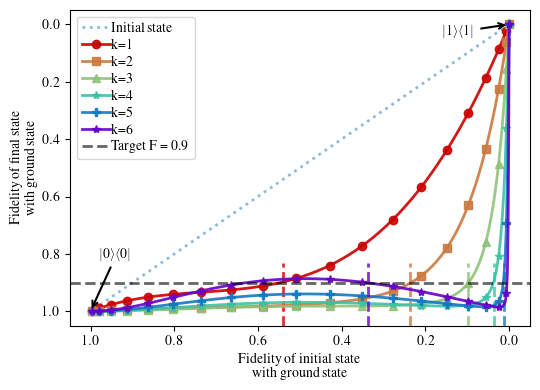

In [5]:
state_0 = np.array([1, 0], dtype=complex)
def fidelity_with_0(state):
    shape = np.shape(state)
    if shape[0] == shape[1]:
        return np.real(np.conj(state_0).T @ state @ state_0)
    else:
        dm = state@state.T.conj()
        return np.real(np.conj(state_0).T @ dm @ state_0)
    
fidelities_original = [fidelity_with_0(x) for x in psis]

max_ext_list = []
fig, ax =  plt.subplots(figsize=(5.5,4))
fidelity = [(1-E)/2 for E in res_init]
ax.plot(fidelities_original,fidelity,label=r"Initial state", alpha=0.5,linestyle=':')

i=0
for key,value in dict_fid_RGCI.items():
    max_ext = max_excitation(fidelities_original,np.real(value),target_fidelity)
    if max_ext is not None:
        ax.axvline(x=max_ext,ymax=0.2, color=color[i], alpha=0.8,linestyle='--')
        max_ext_list.append(max_ext)

    ax.plot(fidelities_original,value,label=key,color=color[i],marker=markers[i],markevery=5,markersize=6,alpha=0.9)
    i+=1

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.ylabel('Fidelity of final state\nwith ground state')
plt.xlabel('Fidelity of initial state\nwith ground state')
ax.axhline(y=target_fidelity, color='k', alpha=0.6,label=r'Target F = 'f'{target_fidelity}',linestyle='--')
ax.legend()

ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=(fidelities_original[0], fidelity[0]), 
            xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
            arrowprops=dict(arrowstyle='->', lw=1.5),
            ha='right', va='bottom')

ax.annotate(r'$|0\rangle\langle 0|$',
            xy=(fidelities_original[-1], fidelity[-1]),  # Point to the data
            xytext=(fidelities_original[-1] - 0.1, fidelity[-1] - 0.22),  # Text location
            arrowprops=dict(arrowstyle='->', lw=1.5),
            ha='right', va='top')

plt.tight_layout()
plt.savefig(f'plots/QITE_DME_M_50_fidelity_final_vs_original.pdf')


In [6]:
psi0 = np.sqrt(1/2)*np.array([[1],[1j]])
psi0 = np.array([[0],[1]])
psis = []
number_steps = 100
thetas = np.linspace(0,1,number_steps)
sigma_x_np = np.array([[0,1],
                       [1,0]])
for i in thetas:
    psis.append(expm(-1j*np.pi/2*sigma_x_np*i) @ psi0)
psis = np.asarray(psis)

res_init = []
dict_res_DBQITE = {}

for psi0 in psis:
    res_init.append(GCI(initial_psi, psi0, 1, np.linspace(0.01,1,2)).execute_gci()[0][-1])   

target_fidelity = 0.9
for k in range(1,7):
    print(k)
    res_DBQITE = []
    for psi0 in psis:
        res_DBQITE.append(GCI(ideal_DME, psi0, None, optimal_s[:k]).execute_gci()[0][-1])
        dict_res_DBQITE.update({f'k={k}' : res_DBQITE})

0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of interval reached
0 0 0.01 --- Warning edge of inter

In [7]:
dict_fid_RGCI = {key: [(1-E)/2 for E in values] for key, values in dict_res_DBQITE.items()}
# dict_fid_RGCI_E = {key: values for key, values in dict_res_DBQITE.items()}


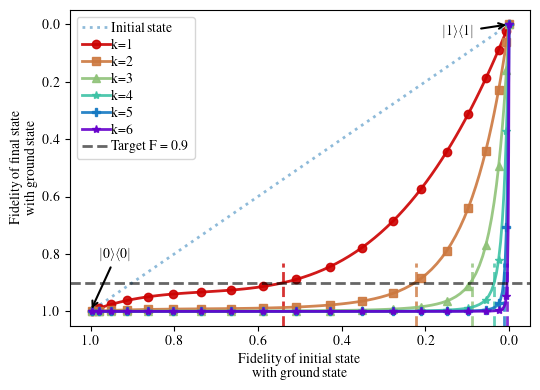

In [8]:
fidelities_original = [fidelity_with_0(x) for x in psis]

max_ext_list = []
fig, ax =  plt.subplots(figsize=(5.5,4))
fidelity = [(1-E)/2 for E in res_init]
ax.plot(fidelities_original,fidelity,label=r"Initial state", alpha=0.5,linestyle=':')

i=0
for key,value in dict_fid_RGCI.items():
    max_ext = max_excitation(fidelities_original,np.real(value),target_fidelity)
    if max_ext is not None:
        ax.axvline(x=max_ext,ymax=0.2, color=color[i], alpha=0.8,linestyle='--')
        max_ext_list.append(max_ext)

    ax.plot(fidelities_original,value,label=key,color=color[i],marker=markers[i],markevery=5,markersize=6,alpha=0.9)
    i+=1

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.ylabel('Fidelity of final state\nwith ground state')
plt.xlabel('Fidelity of initial state\nwith ground state')
ax.axhline(y=target_fidelity, color='k', alpha=0.6,label=r'Target F = 'f'{target_fidelity}',linestyle='--')
ax.legend()


ax.annotate(r'$|1\rangle\langle 1|$', 
            xy=(fidelities_original[0], fidelity[0]), 
            xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
            arrowprops=dict(arrowstyle='->', lw=1.5),
            ha='right', va='bottom')

ax.annotate(r'$|0\rangle\langle 0|$',
            xy=(fidelities_original[-1], fidelity[-1]),  # Point to the data
            xytext=(fidelities_original[-1] - 0.1, fidelity[-1] - 0.22),  # Text location
            arrowprops=dict(arrowstyle='->', lw=1.5),
            ha='right', va='top')

plt.tight_layout()
plt.savefig(f'plots/QITE_ideal_DME_fidelity_final_vs_original.pdf')


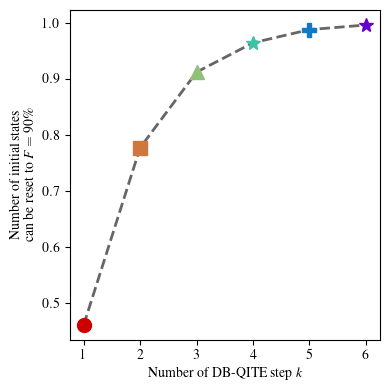

In [9]:
plt.figure(figsize=(4, 4))

x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

plt.plot(range(1,7),[1-max_ext for max_ext in max_ext_list], color='k', alpha=0.6,linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    plt.plot(x, y, marker=markers[i % len(markers)], color=color[i], markersize=10, linestyle='None')

plt.xlabel(r'Number of DB-QITE step $k$')
plt.ylabel('Number of initial states \n' + r'can be reset to $F=90\%$')
plt.tight_layout()
plt.savefig(f'plots/QITE_ideal_DME_number_init_state.pdf')
plt.show()

In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.linalg import expm

# sigma_x = np.array([[0, 1], [1, 0]])
# thetas = np.linspace(0, 1, 100)
# psis = np.array([expm(-1j * np.pi/2 * sigma_x * t) @ [[1], [0]] for t in thetas])
# state_0 = np.array([1, 0], dtype=complex)

# def fidelity_with_0(state):
#     rho = state @ state.T.conj() if state.ndim == 2 else state
#     return np.real(state_0.conj().T @ rho @ state_0)

# fidelities_original = [fidelity_with_0(psi) for psi in psis]
# res_init = [GCI(initial_psi, psi, 1, np.linspace(0.01, 1, 2)).execute_gci()[0][-1] for psi in psis]

# ticks = [0, np.pi/8, np.pi/4, 3*np.pi/8, np.pi/2]
# tick_labels = [r'$0$', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$']

# fig, ax = plt.subplots()
# ax.plot(thetas*np.pi/2, res_init, label="Initial state", color='C0', linestyle=':', alpha=0.6)

# for i, (label, ydata) in enumerate(dict_fid_RGCI.items()):
#     ydata = ydata[::-1]
#     ax.plot(thetas*np.pi/2, ydata, label=f'$k={i}$', 
#             color=color[i], marker=markers[i], markevery=5, markersize=6, alpha=0.9)

# ax.set_xlabel(r'$\theta,$ Angle of initialisation')
# ax.set_ylabel('Data qubit energy')
# ax.set_xticks(ticks)
# ax.set_xticklabels(tick_labels)
# ax.annotate(r'$|1\rangle\langle 1|$', xy=((thetas*np.pi/2)[-1], res_init[-1]), 
#             xytext=((thetas*np.pi/2)[-1]-0.17, res_init[-1]-0.6),
#             arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)
# ax.annotate(r'$|0\rangle\langle 0|$', xy=((thetas*np.pi/2)[0], res_init[0]), 
#             xytext=((thetas*np.pi/2)[0], res_init[0]+0.5),
#             arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)

# ax.legend(fontsize=10)
# plt.tight_layout()
# plt.show()
# plt.close()


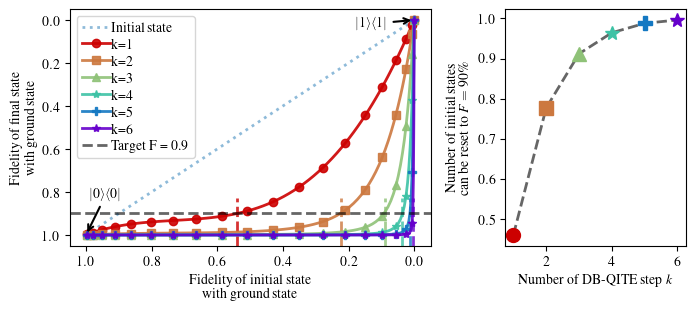

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["twocol"]
# Our figure's aspect ratio
golden = 2.2
# Plot config
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True
})

# Set up figure with custom width ratios
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 3])

# === First Plot (6x4) ===
ax1 = fig.add_subplot(gs[0])
fidelities_original = [fidelity_with_0(x) for x in psis]
fidelity = [(1-E)/2 for E in res_init]
max_ext_list = []

ax1.plot(fidelities_original, fidelity, label=r"Initial state", alpha=0.5, linestyle=':')

for i, (key, value) in enumerate(dict_fid_RGCI.items()):
    max_ext = max_excitation(fidelities_original, np.real(value), target_fidelity)
    if max_ext is not None:
        ax1.axvline(x=max_ext, ymax=0.2, color=color[i], alpha=0.8, linestyle='--')
        max_ext_list.append(max_ext)

    ax1.plot(fidelities_original, value, label=key, color=color[i], marker=markers[i], 
             markevery=5, markersize=6, alpha=0.9)

ax1.invert_xaxis()
ax1.invert_yaxis()

ax1.set_ylabel('Fidelity of final state\nwith ground state')
ax1.set_xlabel('Fidelity of initial state\nwith ground state')
ax1.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--', 
            label=fr'Target F = {target_fidelity}')
ax1.legend()

ax1.annotate(r'$|1\rangle\langle 1|$', 
             xy=(fidelities_original[0], fidelity[0]), 
             xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='bottom')

ax1.annotate(r'$|0\rangle\langle 0|$', 
             xy=(fidelities_original[-1], fidelity[-1]), 
             xytext=(fidelities_original[-1] - 0.11, fidelity[-1] - 0.22), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='top')

# === Second Plot (3x4) ===
ax2 = fig.add_subplot(gs[1])
x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

ax2.plot(x_vals, y_vals, color='k', alpha=0.6, linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    ax2.plot(x, y, marker=markers[i % len(markers)], color=color[i], 
             markersize=10, linestyle='None')

ax2.set_xlabel(r'Number of DB-QITE step $k$')
ax2.set_ylabel('Number of initial states \n' + r'can be reset to $F=90\%$')

plt.tight_layout()
plt.savefig('plots/QITE_ideal_DME_merged.pdf')
plt.show()


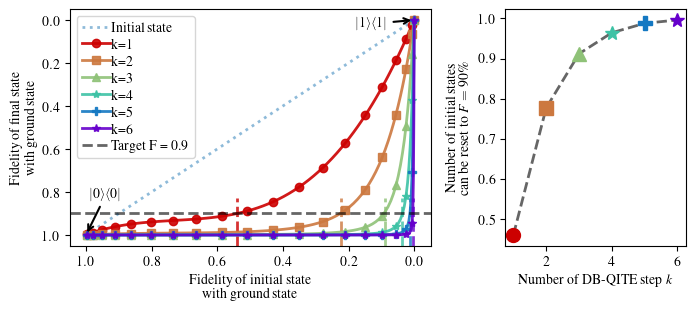

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["twocol"]
# Our figure's aspect ratio
golden = 2.2
# Plot config
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True
})

# Set up figure with custom width ratios
fig = plt.figure()
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 3])

# === First Plot (6x4) ===
ax1 = fig.add_subplot(gs[0])
fidelities_original = [fidelity_with_0(x) for x in psis]
fidelity = [(1-E)/2 for E in res_init]
max_ext_list = []

ax1.plot(fidelities_original, fidelity, label=r"Initial state", alpha=0.5, linestyle=':')

for i, (key, value) in enumerate(dict_fid_RGCI.items()):
    max_ext = max_excitation(fidelities_original, np.real(value), target_fidelity)
    if max_ext is not None:
        ax1.axvline(x=max_ext, ymax=0.2, color=color[i], alpha=0.8, linestyle='--')
        max_ext_list.append(max_ext)

    ax1.plot(fidelities_original, value, label=key, color=color[i], marker=markers[i], 
             markevery=5, markersize=6, alpha=0.9)

ax1.invert_xaxis()
ax1.invert_yaxis()

ax1.set_ylabel('Fidelity of final state\nwith ground state')
ax1.set_xlabel('Fidelity of initial state\nwith ground state')
ax1.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--', 
            label=fr'Target F = {target_fidelity}')
ax1.legend()

ax1.annotate(r'$|1\rangle\langle 1|$', 
             xy=(fidelities_original[0], fidelity[0]), 
             xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='bottom')

ax1.annotate(r'$|0\rangle\langle 0|$', 
             xy=(fidelities_original[-1], fidelity[-1]), 
             xytext=(fidelities_original[-1] - 0.11, fidelity[-1] - 0.22), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='top')

# === Second Plot (3x4) ===
ax2 = fig.add_subplot(gs[1])
x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

ax2.plot(x_vals, y_vals, color='k', alpha=0.6, linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    ax2.plot(x, y, marker=markers[i % len(markers)], color=color[i], 
             markersize=10, linestyle='None')

ax2.set_xlabel(r'Number of DB-QITE step $k$')
ax2.set_ylabel('Number of initial states \n' + r'can be reset to $F=90\%$')

plt.tight_layout()
plt.savefig('plots/QITE_ideal_DME_merged.pdf')
plt.show()


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
import sys
sys.path.append('..')
from functions.qite_gci import *
from functions.qite_dme import *

# Parameters
max_k, max_M = 7, 10
psi0 = np.sqrt(0.5) * np.array([[1], [1j]])

# Optimize step sizes s for each (M,k)
optimal_s_Mk = []
for M in range(1, max_M+1):
    s_list = []
    for k in range(1, max_k+1):
        def obj(s):
            return GCI(QITE_dme_select_M(M), psi0, None, s_list + [s]).execute_gci()[0][-1].real
        res = minimize(obj, np.pi/4, method='Nelder-Mead')
        s_list.append(res.x[0])
    optimal_s_Mk.append(s_list)
optimal_s_Mk = np.array(optimal_s_Mk)
np.save('optimal_s_Mk', optimal_s_Mk)
optimal_s_kM = optimal_s_Mk.T

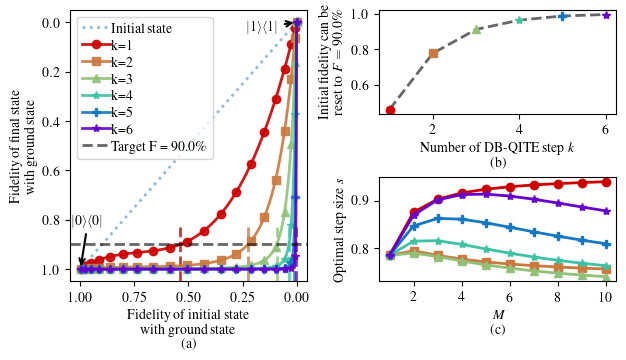

In [13]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["twocol"]
# Our figure's aspect ratio
golden = 2
# Plot config
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True,
})

# Set up figure with custom width ratios
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.6, wspace=0.3)

# === First Plot (6x4) ===
ax1 = fig.add_subplot(gs[:,0])
fidelities_original = [fidelity_with_0(x) for x in psis]
fidelity = [(1-E)/2 for E in res_init]
max_ext_list = []

ax1.plot(fidelities_original, fidelity, label=r"Initial state", alpha=0.5, linestyle=':')

for i, (key, value) in enumerate(dict_fid_RGCI.items()):
    max_ext = max_excitation(fidelities_original, np.real(value), target_fidelity)
    if max_ext is not None:
        ax1.axvline(x=max_ext, ymax=0.2, color=color[i], alpha=0.8, linestyle='--')
        max_ext_list.append(max_ext)

    ax1.plot(fidelities_original, value, label=key, color=color[i], marker=markers[i], 
             markevery=5, markersize=6, alpha=0.9)

ax1.invert_xaxis()
ax1.invert_yaxis()

ax1.set_ylabel('Fidelity of final state\nwith ground state')
ax1.set_xlabel('Fidelity of initial state\nwith ground state'+'\n(a)')
ax1.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--', 
            label=fr'Target F = {target_fidelity*100}\%')
ax1.legend()

ax1.annotate(r'$|1\rangle\langle 1|$', 
             xy=(fidelities_original[0], fidelity[0]), 
             xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='bottom')

ax1.annotate(r'$|0\rangle\langle 0|$', 
             xy=(fidelities_original[-1], fidelity[-1]), 
             xytext=(fidelities_original[-1] - 0.11, fidelity[-1] - 0.22), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='top')

# === Second Plot (3x4) ===
ax2 = fig.add_subplot(gs[0,1])
x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

ax2.plot(x_vals, y_vals, color='k', alpha=0.6, linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    ax2.plot(x, y, marker=markers[i % len(markers)], color=color[i], 
             markersize=6, linestyle='None')

ax2.set_xlabel(r'Number of DB-QITE step $k$'+'\n(b)')
ax2.set_ylabel('Initial fidelity can be\n' + r'reset to $F=90.0\%$')

# ===
ax3 = fig.add_subplot(gs[1,1])
for i, s_list in enumerate(optimal_s_kM[:-1]):
    # s_plot = [x if x > 0.6 else None for x in s_list]
    ax3.plot(range(1, max_M+1),s_list, color=color[i], label=f'k={i+1}',marker=markers[i],markersize=6 )
    # plt.plot(s_list, label=f'k={i+1}')

ax3.set_ylabel(r'Optimal step size $s$')
ax3.set_xlabel(r'$M$'+'\n(c)')

plt.tight_layout()
plt.savefig('plots/QITE_ideal_DME_merged.pdf')
plt.show()


NameError: name 'dict_fid_RGCI_E' is not defined

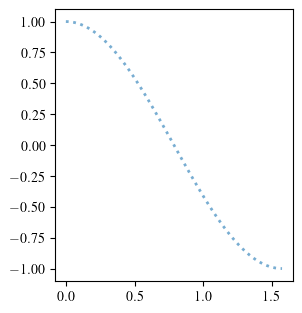

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["twocol"]
# Our figure's aspect ratio
golden = 2
# Plot config
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True,
})

# Set up figure with custom width ratios
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], hspace=0.6, wspace=0.3)

# === First Plot (6x4) ===
ax1 = fig.add_subplot(gs[:,0])
fidelities_original = [fidelity_with_0(x) for x in psis]
fidelity = [(1-E)/2 for E in res_init]
max_ext_list = []

ax1.plot(thetas*np.pi/2, res_init, label="Initial state", color='C0', linestyle=':', alpha=0.6)

for i, (label, ydata) in enumerate(dict_fid_RGCI_E.items()):
    ydata = ydata[::-1]
    ax1.plot(thetas*np.pi/2, ydata, label=f'$k={i}$', 
             color=color[i], marker=markers[i], markevery=5, markersize=6, alpha=0.9)

ax1.set_xlabel(r'$\theta,$ Angle of initialisation')
ax1.set_ylabel('Data qubit energy')
ax1.set_xticks(ticks)
ax1.set_xticklabels(tick_labels)
ax1.annotate(r'$|1\rangle\langle 1|$', xy=((thetas*np.pi/2)[-1], res_init[-1]), 
             xytext=((thetas*np.pi/2)[-1]-0.17, res_init[-1]-0.6),
             arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)
ax1.annotate(r'$|0\rangle\langle 0|$', xy=((thetas*np.pi/2)[0], res_init[0]), 
             xytext=((thetas*np.pi/2)[0], res_init[0]+0.5),
             arrowprops=dict(arrowstyle='->', lw=1.5), zorder=10)
ax1.legend()

# === Second Plot (3x4) ===
ax2 = fig.add_subplot(gs[0,1])
x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

ax2.plot(x_vals, y_vals, color='k', alpha=0.6, linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    ax2.plot(x, y, marker=markers[i % len(markers)], color=color[i], 
             markersize=6, linestyle='None')

ax2.set_xlabel(r'Number of DB-QITE step $k$'+'\n(b)')
ax2.set_ylabel('Initial fidelity can be\n' + r'reset to $F=90.0\%$')

# ===
ax3 = fig.add_subplot(gs[1,1])
for i, s_list in enumerate(optimal_s_kM[:-1]):
    # s_plot = [x if x > 0.6 else None for x in s_list]
    ax3.plot(range(1, max_M+1),s_list, color=color[i], label=f'k={i+1}',marker=markers[i],markersize=6 )
    # plt.plot(s_list, label=f'k={i+1}')

ax3.set_ylabel(r'Optimal step size $s$')
ax3.set_xlabel(r'$M$'+'\n(c)')

plt.tight_layout()
plt.savefig('plots/QITE_ideal_DME_merged.pdf')
plt.show()


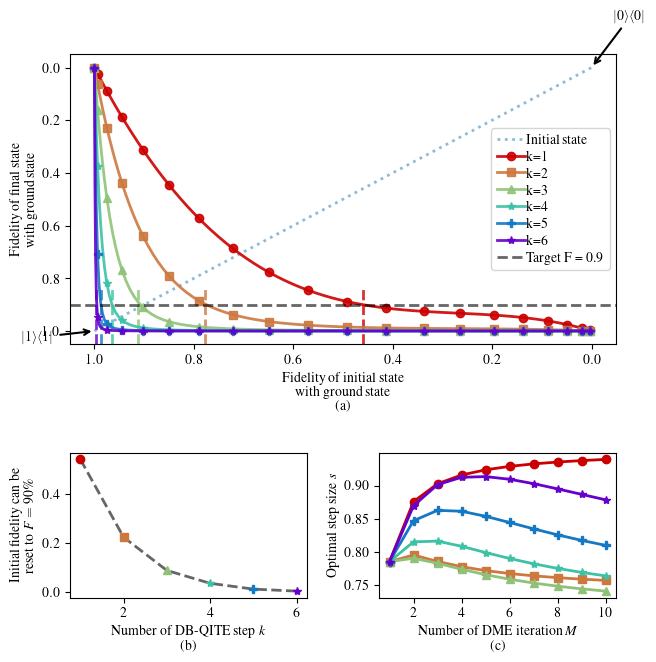

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
dict_fid_RGCI = {key: [(1-E)/2 for E in values] for key, values in dict_res_DBQITE.items()}
pt = 1./72.27 # Hundreds of years of history... 72.27 points to an inch.
jour_sizes = {"PRD": {"onecol": 246.*pt, "twocol": 510.*pt},
              "CQG": {"onecol": 374.*pt}, # CQG is only one column
              # Add more journals below. Can add more properties to each journal
             }

my_width = jour_sizes["PRD"]["twocol"]
# Our figure's aspect ratio
golden = 1
# Plot config
plt.rcParams.update({
    'font.size': 10,
    'savefig.dpi': 75,
    'lines.linewidth': 2.0,
    'lines.markersize': 8,
    'legend.labelspacing': .3,
    'legend.columnspacing': .3,
    'legend.handletextpad': .1,
    'text.usetex': True,
    'font.family': "serif",
    'font.serif': "Times",
    'figure.figsize': [my_width,my_width/golden],
    'figure.autolayout': True,
})

# Set up figure with custom width ratios
fig = plt.figure()
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 0.5], hspace=0.5, wspace=0.3)

# === First Plot (6x4) ===
ax1 = fig.add_subplot(gs[0,:])
fidelities_original = [fidelity_with_0(x) for x in psis]
fidelity = [(1-E)/2 for E in res_init]
max_ext_list = []

ax1.plot(fidelities_original, fidelity, label=r"Initial state", alpha=0.5, linestyle=':')

for i, (key, value) in enumerate(dict_fid_RGCI.items()):
    max_ext = max_excitation(fidelities_original, np.real(value), target_fidelity)
    if max_ext is not None:
        ax1.axvline(x=max_ext, ymax=0.2, color=color[i], alpha=0.8, linestyle='--')
        max_ext_list.append(max_ext)

    ax1.plot(fidelities_original, value, label=key, color=color[i], marker=markers[i], 
             markevery=5, markersize=6, alpha=0.9)



ax1.set_ylabel('Fidelity of final state\nwith ground state')
ax1.set_xlabel('Fidelity of initial state\nwith ground state'+'\n(a)')
ax1.axhline(y=target_fidelity, color='k', alpha=0.6, linestyle='--', 
            label=fr'Target F = {target_fidelity}')
ax1.legend()

ax1.annotate(r'$|1\rangle\langle 1|$', 
             xy=(fidelities_original[0], fidelity[0]), 
             xytext=(fidelities_original[0]+0.08, fidelity[0]+0.05), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='bottom')

ax1.annotate(r'$|0\rangle\langle 0|$', 
             xy=(fidelities_original[-1], fidelity[-1]), 
             xytext=(fidelities_original[-1] - 0.11, fidelity[-1] - 0.22), 
             arrowprops=dict(arrowstyle='->', lw=1.5),
             ha='right', va='top')
ax1.invert_xaxis()
ax1.invert_yaxis()

# === Second Plot (3x4) ===
ax2 = fig.add_subplot(gs[1,0])
x_vals = range(1, len(max_ext_list) + 1)
y_vals = [1 - max_ext for max_ext in max_ext_list]

ax2.plot(x_vals, y_vals, color='k', alpha=0.6, linestyle='--')

for i, (x, y) in enumerate(zip(x_vals, y_vals)):
    ax2.plot(x, y, marker=markers[i % len(markers)], color=color[i], 
             markersize=6, linestyle='None')

ax2.set_xlabel(r'Number of DB-QITE step $k$'+'\n(b)')
ax2.set_ylabel('Initial fidelity can be\n' + r'reset to $F=90\%$')

# ===
ax3 = fig.add_subplot(gs[1,1])
for i, s_list in enumerate(optimal_s_kM[:-1]):
    # s_plot = [x if x > 0.6 else None for x in s_list]
    ax3.plot(range(1, max_M+1),s_list, color=color[i], label=f'k={i+1}',marker=markers[i],markersize=6 )
    # plt.plot(s_list, label=f'k={i+1}')

ax3.set_ylabel(r'Optimal step size $s$')
ax3.set_xlabel(r'Number of DME iteration $M$'+'\n(c)')

plt.tight_layout()
plt.savefig('plots/QITE_ideal_DME_merged.pdf')
plt.show()
